# Inferential Statistics

After cleaning and getting a general idea of the data, I'm going to do some hypothesis testing on the categorical variables and some regression analysis to see which, if any, of the numerical variables contribute significantly to the predicted variable, the weekly revenue.

In [121]:
#importing necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler

In [122]:
#Reading in the csv file and looking at the first five rows
df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Capstone 2\data\Interim\train1.csv',index_col=0)
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,MarkDown5,CPI,Unemployment,Size,Type_A,Type_B,Type_C,log_revenue,IsMarkDown,Type_barplot
0,26,92,2011-08-26,87235.57,False,61.10,3.796,0.00,0.0,0.0,...,0.00,136.213613,7.767,152513,1,0,0,11.431992,False,A
1,34,22,2011-03-25,5945.97,False,53.11,3.480,0.00,0.0,0.0,...,0.00,128.616064,10.398,158114,1,0,0,9.299807,False,A
2,21,28,2010-12-03,1219.89,False,50.43,2.708,0.00,0.0,0.0,...,0.00,211.265543,8.163,140167,0,1,0,8.733889,False,B
3,8,9,2010-09-17,11972.71,False,75.32,2.582,0.00,0.0,0.0,...,0.00,214.878556,6.315,155078,1,0,0,9.738769,False,A
4,19,55,2012-05-18,8271.82,False,58.81,4.029,12613.98,0.0,11.5,...,3600.79,138.106581,8.150,203819,1,0,0,9.492640,False,A


In [123]:
#Reminder of the type of the columns included
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282450 entries, 0 to 282450
Data columns (total 21 columns):
Store           282450 non-null int64
Dept            282450 non-null int64
Date            282450 non-null object
Weekly_Sales    282450 non-null float64
IsHoliday       282450 non-null bool
Temperature     282450 non-null float64
Fuel_Price      282450 non-null float64
MarkDown1       282450 non-null float64
MarkDown2       282450 non-null float64
MarkDown3       282450 non-null float64
MarkDown4       282450 non-null float64
MarkDown5       282450 non-null float64
CPI             282450 non-null float64
Unemployment    282450 non-null float64
Size            282450 non-null int64
Type_A          282450 non-null int64
Type_B          282450 non-null int64
Type_C          282450 non-null int64
log_revenue     282450 non-null float64
IsMarkDown      282450 non-null bool
Type_barplot    282450 non-null object
dtypes: bool(2), float64(11), int64(6), object(2)
memory usage: 43.6+

## Categorical variables:

For the boolean categorical variables (IsHoliday and IsMarkDown), I'm going to perform a frequentist hypothesis test to see if the weekly sales are different between the two categories. For the Type column, which contains 3 options, I'm going to do an ANOVA (Analysis of Variance) test to see if the type of store is relevant for the revenue prediction.

There are three requirements that must be met for frequentist hypothesis testing: 
* First, the samples must be independent. 

This assumption may be questionable, because the dataset has a time-series element to it and each week's revenue may have an impact on the revenue next week. For our purposes, though, we can assume that that each row is an independent observation based only on the features. If I have time, I can utilize a more Times Series based approach.
* Second, the samples must be random. 

This is an assumption, but since the description of the dataset doesn’t mention any biases in selection we can assume that there is none. 
* Third, the distribution must be normal. 

By “distribution” here, we are referring to the distribution of the mean of the data according to the central limit theorem, which means that the sample data should either be 1) normal, or 2) greater than 30. As both the test and training data have more than 30 entries, this condition is satisfied.

### Holiday

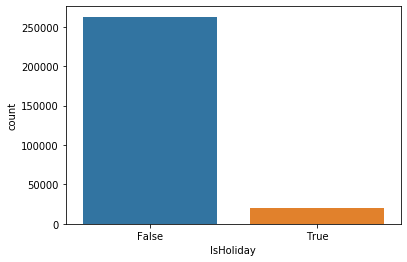

In [124]:
#The number of entries for each IsHoliday option.
sns.countplot(x='IsHoliday', data=df)

As can be seen above, the number of weeks that are not holidays vastly outnumber weeks that are holidays. This may have an impact on our hypothesis testing later, but since both contain more than 30 entires the samples can still be said to be independent. Next, we find the mean and standard deviation for each option and perform a hypothesis test.

#### Holiday == True

First, we're going to find the mean and standard deviation of the weekly sales made during holiday weeks. As we're going to be doing this a lot, it might be helpful to write a function.

In [125]:
#As we're going to be doing this a lot, it might be helpful to write a function.

def find_mean_std_count(condition):
    mean = round(df[condition]['Weekly_Sales'].mean(),2)
    std = round(df[condition]['Weekly_Sales'].std(),2)
    count = df[condition].shape[0]
    return mean,std,count

holiday_mean, holiday_std, holiday_count = (find_mean_std_count(df['IsHoliday']==True))

In [126]:
holiday_mean

16986.67

In [127]:
holiday_std

26955.16

In [128]:
holiday_count

19819

The standard deviation is larger than the mean, which is probably due to there being some very large outliers. Next we can compare the value to those of sales made in non-holiday weeks.

#### Holiday == False

In [129]:
#Find the mean, standard deviation, and number of values in non-holiday weeks.
no_holiday_mean, no_holiday_std, no_holiday_count = (find_mean_std_count(df['IsHoliday']==False))

In [130]:
no_holiday_mean

15907.8

In [131]:
no_holiday_std

22301.76

In [132]:
no_holiday_count

262631

Alright, so a similar pattern emerges for sales made in non-holiday weeks. Given the exponential nature of the Weekly sales, this may be a common occurence. Now let's do the hypothesis test. The large intra-group variance, however, brings some doubt to the signficance of the results.

#### Hypothesis test

In [133]:
H0 = "The mean weekly revenue for holiday weeks equal to the mean weekly revenue for non-holiday weeks."
H1 = "There is a difference between the mean weekly revenue for holiday weeks and non-holiday weeks."

#Hypothesis testing
alpha = 0.05

diff = holiday_mean - no_holiday_mean
comb_var = holiday_std ** 2 / holiday_count + no_holiday_std ** 2 / no_holiday_count
se = np.sqrt(comb_var)

t_score = (diff - 0) / se
t_score

5.494535557529593

In [134]:
#Finding the p-value
dof = holiday_count + no_holiday_count - 2
p = 1 - stats.t.cdf(t_score, df=dof)
p

1.9603840217818913e-08

In [135]:
if p < 0.05:
    print(H1)
else:
    print(H0)

There is a difference between the mean weekly revenue for holiday weeks and non-holiday weeks.


### Markdown

Next, we can look at whether having a markdown influences the sales or not. We're going to follow a similar pattern as shown for the Holiday section, starting with looking at the number of values for each IsMarkDown option, True and False.

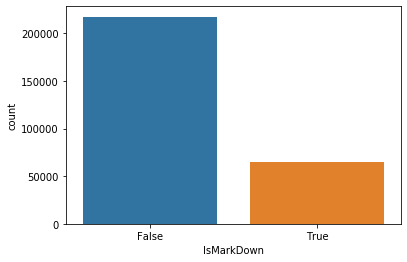

In [136]:
sns.countplot(x='IsMarkDown',data=df)

As seen, there are a lot less weeks with markdowns compared to weeks without. Let's then look at how their mean and standard deviation compares wth each other.

#### IsMarkDown == True

In [137]:
#Find the mean, standard deviation, and count
markdown_mean, markdown_std, markdown_count = find_mean_std_count(df['IsMarkDown'])

In [138]:
markdown_mean

17867.04

In [139]:
markdown_std

24729.34

In [140]:
markdown_count

64818

#### Holiday == False

In [141]:
#Find the mean, standard deviation, and count
no_markdown_mean, no_markdown_std, no_markdown_count = (find_mean_std_count(df['IsMarkDown']==False))

In [142]:
no_markdown_mean

15422.52

In [143]:
no_markdown_std

21976.46

In [144]:
no_markdown_count

217632

#### Hypothesis test

In [145]:
H0 = "The mean weekly revenue for markdown weeks equal to the mean weekly revenue for non-markdown weeks."
H1 = "There is a difference between the mean weekly revenue for markdown weeks and non-markdown weeks."

#Hypothesis testing
alpha = 0.05

diff = markdown_mean - no_markdown_mean
comb_var = markdown_std ** 2 / markdown_count + no_markdown_std ** 2 / no_markdown_count
se = np.sqrt(comb_var)

t_score = (diff - 0) / se
t_score

22.644240954591954

In [146]:
#Finding the p-value
dof = markdown_count + no_markdown_count - 2
p = 1 - stats.t.cdf(t_score, df=dof)
p

0.0

In [147]:
if p < 0.05:
    print(H1)
else:
    print(H0)

There is a difference between the mean weekly revenue for markdown weeks and non-markdown weeks.


### Store Type

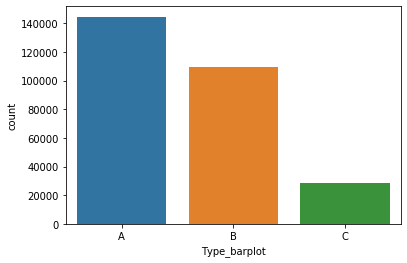

In [164]:
sns.countplot(x='Type_barplot',data=df)

In [165]:
#Find mean, standard deviation, and count.
type_a_mean, type_a_std, type_a_count = find_mean_std_count(df['Type_barplot']=='A')
type_b_mean, type_b_std, type_b_count = find_mean_std_count(df['Type_barplot']=='B')
type_c_mean, type_c_std, type_c_count = find_mean_std_count(df['Type_barplot']=='C')

#### Type A:

In [166]:
type_a_mean

20079.34

In [167]:
type_a_std

26306.11

In [168]:
type_a_count

144558

#### Type B:

In [169]:
type_b_mean

12263.65

In [170]:
type_b_std

17273.14

In [171]:
type_b_count

109413

#### Type C

In [172]:
type_c_mean

9484.48

In [173]:
type_c_std

15926.32

In [174]:
type_c_count

28479

#### ANOVA test

In [175]:
#ANOVA test
total_mean = df['Weekly_Sales'].mean()

sst = type_a_count * (type_a_mean - total_mean)**2 + type_b_count * (type_b_mean - total_mean)**2 + type_c_count * (type_c_mean - total_mean)**2
    
sse = (type_a_count - 1) * type_a_std ** 2 + (type_b_count - 1) * type_b_std ** 2 + (type_c_count - 1) * type_c_std ** 2

mst = sst / 2

mse = sse / (type_a_count + type_b_count + type_c_count - 3)

f_value = mst / mse

In [176]:
f_value

5190.486106885268

In [180]:
H0 = "There is no difference between the different types of stores in terms of revenue."
H1 = "There is a difference between at least two different types of stores when it comes to revenue."

if f_value > 3: #The required F-value to be significant
    print(H1)
else:
    print(H0)

There is a difference between at least two different types of stores when it comes to revenue.


### Linear Regression analysis.

To look at how the numerical variables impact the revenue, I'm going to plug them all into statsmodel's OLS regression and look at the values given.

In [188]:
#As I am too lazy to put all of the numerical values in by hand I wrote a for loop to take care of that.

#Writing statement
stmt = 'Weekly_Sales ~ '
for x in df.columns:
    if df[x].dtype == 'float64' and x != 'Weekly_Sales' and x != 'log_revenue':
        stmt = stmt + x + ' + '

#Excising unnecessary parts.
stmt = stmt[:-3]

In [189]:
#Running the model
m = ols(stmt,df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     226.0
Date:                Mon, 30 Sep 2019   Prob (F-statistic):               0.00
Time:                        16:02:02   Log-Likelihood:            -3.2323e+06
No. Observations:              282450   AIC:                         6.465e+06
Df Residuals:                  282440   BIC:                         6.465e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     2.606e+04    494.488     52.710   

Looks like there are some collinearity problems. I suspect that may be due to the markdown columns being very intercorrelated with each other, so I'm going to put IsMarkDown in instead and see if that might erase that issue.

In [183]:
m = ols('Weekly_Sales ~ Temperature + Fuel_Price + CPI + Unemployment + IsMarkDown',df).fit()
print(m.summary())

                            OLS Regression Results                            
Dep. Variable:           Weekly_Sales   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     227.0
Date:                Mon, 30 Sep 2019   Prob (F-statistic):          1.01e-242
Time:                        13:49:08   Log-Likelihood:            -3.2327e+06
No. Observations:              282450   AIC:                         6.465e+06
Df Residuals:                  282444   BIC:                         6.466e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.526e+04    490

The condition number has decreased, meaning we successfully reduced some of the multicollinearity, albeit not all of it. Nevertheless, we can see the impact of several of our variables. Fuel Price, CPI, and Unemployment all have a negative impact on the weekly revenue, while temperature and Markdowns have a positive value.